# Bond Sensitivities

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.optimize
import init

## Building the Yield Curve

Since Bond Prices are a little more involved to find than stock prices, we can use this opportunity to practice building a term-structure from interest rates.

In [5]:
# building interest rates
# T is yearly
# Read tables from a webpage
tables = pd.read_html('https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025')

In [6]:
yesterday_info = tables[0].iloc[-1]

In [7]:
maturities = [1/12, 1.5/12, 2/12, 3/12, 4/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yields = yesterday_info.to_list()[12:]
yields = [ y/100 for y in yields]

In [8]:
# Cubic spline is a popular method for Term Structure of Interest Rate Curve to Existing yields
from scipy.interpolate import CubicSpline
cs = CubicSpline(maturities, yields, bc_type='natural')

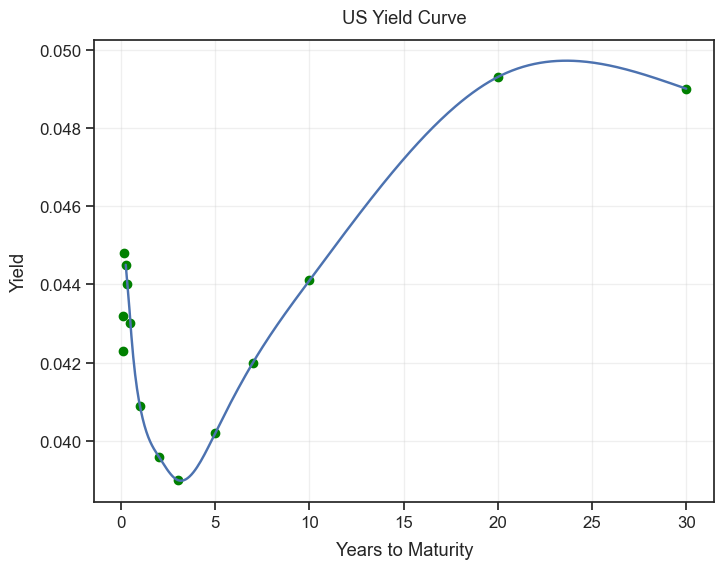

In [9]:
x_new = np.linspace(0.25, 30, 300)
y_new = cs(x_new)
plt.scatter(maturities,yields, color='green')
plt.plot(x_new, y_new)
plt.xlabel("Years to Maturity")
plt.ylabel("Yield")
plt.title("US Yield Curve")
plt.show()

## Building Bonds

In [99]:
class Bond:
    # compound period - how many times a year the i.r. is compounded
    def __init__(self, term_structure, coupon_rate=0.02, compound_period=2, ttm=2, face_value=1):
        self.coupon_rate = coupon_rate
        self.compound_period = compound_period
        self.ttm = ttm
        self.face_value = face_value
        #build our cash flow df
        self.df = self.get_df()
        # get the rates required to price the bond
        self.rates = term_structure(self.df['date'])
        # get our bond price
        self.price = self.get_price(self.rates)
        self.YTM = self.get_ytm()
        # metrics
        self.dy = self.get_dy(self.YTM)
        self.DV01 = self.get_DV01()
        self.D_mac = self.get_Dmac()
        self.D = self.get_D()
        self.dyy = self.get_dyy(self.YTM)
        self.C = self.get_C()

    def get_df(self):
        # build bond cashflows
        cash_flows = [self.coupon_rate/self.compound_period*self.face_value for _ in range(int(self.ttm*self.compound_period))]
        cash_flows[-1] += self.face_value
        dates = np.arange(1/self.compound_period,self.ttm+(1/self.compound_period),1/self.compound_period)
        print(dates)
        bond_df = pd.DataFrame({'date':dates, 'cash_flow':cash_flows})
        return bond_df

    def get_price(self, rates):
        discount_factors = (1 + rates/self.compound_period)**(-1 * self.df['date']*self.compound_period)
        price = sum(discount_factors * self.df['cash_flow'])
        return price

    def get_ytm(self):
        bond_price_diff = lambda y, prc: prc - self.get_price(y)
        YTM = scipy.optimize.newton(lambda y: bond_price_diff(y, self.price), 0.01, tol=0.00001, maxiter=10_000)
        return YTM

    def get_dy(self, y):
        deriv_df = self.df.copy()
        deriv_df['frac'] = deriv_df['cash_flow'] * (deriv_df['date']) / (1 + y/self.compound_period)**(deriv_df['date']*self.compound_period + 1)
        deriv = -1*sum(deriv_df['frac'])
        return deriv
        
    def get_DV01(self):
        return -1 * 1/10_000 * self.dy

    def get_Dmac(self):
        return -1 * self.dy * 1/self.price * (1 + self.YTM/self.compound_period)

    def get_D(self):
        return self.D_mac/(1 + self.YTM/self.compound_period)

    def get_dyy(self, y):
        double_deriv_df = self.df.copy()
        double_deriv_df['frac'] = double_deriv_df['cash_flow'] * (double_deriv_df['date']) * (double_deriv_df['date']*self.compound_period + 1) / self.compound_period / (1 + y/self.compound_period)**(double_deriv_df['date']*self.compound_period + 2)
        double_deriv = sum(double_deriv_df['frac'])
        return double_deriv

    def get_C(self):
        return self.dyy / self.price

    def get_fd_dy(self, delta_y=0.0001):
        dy = (self.get_price(self.YTM + delta_y) - self.get_price(self.YTM - delta_y) )/ (2 * delta_y)
        return dy

    def get_fd_dyy(self, delta_y=0.0001):
        dy = (self.get_price(self.YTM + delta_y) -2*self.get_price(self.YTM) + self.get_price(self.YTM - delta_y) )/ (delta_y**2)
        return dy

## Sensitivity with repsect to YTM

In [18]:
# we can use a single scaler if all rates are the same
print(f'Yield to Maturity (YTM) of bond: {x.YTM}')

Yield to Maturity (YTM) of bond: 0.039599999997714005


In [19]:
print(f'Price of bond given term structure: {round(x.price,3)}')
print(f'Price of bond given YTM: {round(x.get_price(x.YTM),3)}')

Price of bond given term structure: 0.925
Price of bond given YTM: 0.925


We can simplify movements in the term structure by modeling movements in the bonds YTM. First, we observe the price of a bond as a fuction of its YTM:

$$ B(y,T) = \sum_{i=1}^n \frac{C_{T_i}}{(1 + \frac{y}{n})^{n*T_i}} + \frac{100}{(1 + \frac{y}{n})^{n*T_n}},$$

The sensitivy with repect to the yield follows as

$$ \frac{\partial B(y,T)}{\partial y} = -1 * \sum_{i=1}^n \frac{C_{T_i} * T_i}{(1 + \frac{y}{n})^{n*T_i + 1}} + \frac{100 * T_n}{(1 + \frac{y}{n})^{n*T_n + 1}}.$$

It is important to note that the $y$ defined here is for that period, i.e. annualized YTM per period.

In [21]:
print(f'Derivative of bond price w.r.t yield: {x.dy}.')

Derivative of bond price w.r.t yield: -1.8132386075847224.


## Duration

Now that we have our bonds sensitivty to changes in the yield, we can observe the bonds **Duration**. The different duration measures of a bond are very closely related to the sensitivity of the bond to shifts in yield, but they differ due to "not letting enough math people be involved with bonds from the get to" as one of my old professors explained.

### Dollar Duration (DV01)

$$ -1 * \frac{1}{10,000}\frac{\partial B(y,T)}{\partial y}$$

In [26]:
print(f'DV01 of bond: {x.DV01}')

DV01 of bond: 0.00018132386075847226


Yes, the dollar duration is just the negative of the sensitivty to a bp change. This does nothing other than allow us to think of duration as "amount to lose" instead of "amount to change".

### Macauly Duration

The Macauly Duration is a time weighted average of payments that measures how far in the future a bond is paid off.

$$D_{\text{MAC}} = -1 * \frac{\partial B(y,T)}{\partial y} * \frac{1}{B(y,T)} * (1 + \frac{y}{n})$$

In [29]:
print(f'Macauly Duration of bond: {round(x.D_mac, 3)}')

Macauly Duration of bond: 2.0


### Duration (Modified Duration)

The duration is used to approximate the (*minus*) percentage movement in bond price for a 100 bp ($1\%$) change in the bonds yield.

$$ D = -1 * \frac{\partial B(y,T)}{\partial y} * \frac{1}{B(y,T)} = \frac{D_{\text{MAC}}}{1+\frac{y}{n}}.$$

It is important to note that the "100 bp change" is not observed in the formula, but can be extracted by observing

$$ 
\begin{aligned}
D &= -1 * \left [ \frac{\partial B(y,T)}{\partial y} * \underbrace{0.01}_\text{Sensitivity to 100 bp change} \right ] * \left [ \frac{1}{B(y,T)} * \underbrace{100}_\text{percentage movement} \right ] \\
\\
 &= -1 * \frac{\partial B(y,T)}{\partial y} * \frac{1}{B(y,T)}
\end{aligned}
$$


In [31]:
print(f'Duration of bond: {round(x.D, 3)}')

Duration of bond: 1.961


### Convexity ($C$)

Moving back to direct sensitivities, bond convexity to yield changes in another important metric to observe. The convexity is the rate of change of the sensitivity to changes in the yield.

$$ C = \frac{\partial^2 B(y,T)}{\partial y^2} * \frac{1}{B(y,T)}$$

where

$$ \frac{\partial^2 B(y,T)}{\partial y^2} = \sum_{i=1}^n \frac{C_{T_i} * T_i *(n*T_i + 1)* \frac{1}{n}}{(1 + \frac{y}{n})^{n*T_i + 2}} + \frac{100 * T_n * (n*T_i + 1)*\frac{1}{n}}{(1 + \frac{y}{n})^{n*T_n + 2}}.$$

In [33]:
print(f'Convexity of bond: {x.C}')

Convexity of bond: 9.615458210687127


## General Sensitivity: Finite Difference

For more complex fixed income instruments (such as callable bonds, or Mortgage Backed Securities) we can not use a simple formula for deriving the sensitivity to yield, so we can use the finite difference method for approximating the sensitivity of any fixed income instrument (including zeros) to changes in yield. We denote any duration calculated with the finite differnce scheme as the *Effective Duration*. The finite difference method approximates derivatives as

$$
\begin{aligned}\frac{\partial V(y, \cdot)}{\partial y} &\approx \frac{V(y+\Delta y, \cdot) - V(y-\Delta y, \cdot)}{2\Delta y}\\
\frac{\partial^2 V(y, \cdot)}{\partial y^2} &\approx \frac{V(y+\Delta y, \cdot) -2V(y,\cdot) + V(y-\Delta y, \cdot)}{\Delta y^2}
\end{aligned}$$

Using the Finite Difference method, we can now find all relavent durations and convexity for any fixed income instrument, regardless of the complexity.

In [128]:
print(f'FD real d/dy: {x.get_fd_dy() - x.dy}')

FD real d/dy: -2.1793710613948747e-08


In [130]:
print(f'FD real dd/dyy: {x.get_fd_dyy() - x.dyy}')

FD real dd/dyy: -5.7526006180808054e-08
